<a href="https://colab.research.google.com/github/skywalker0803r/Ricky/blob/master/%E7%8E%89%E5%B1%B1AI%E6%AF%94%E8%B3%BD_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
from google.colab import drive
drive.mount('/content/drive')
import warnings 
warnings.simplefilter('ignore')
import seaborn as sns
import matplotlib.pyplot as plt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
中文map = {'bacno':'歸戶帳號','txkey':'交易序號','locdt':'授權日期','loctm':'授權時間','cano':'交易卡號',
         'contp':'交易類別','etymd':'交易型態','mchno':'特店代號','acqic':'收單行代碼','mcc':'MCC_CODE',
         'conam':'交易金額-台幣(經過轉換)','ecfg':'網路交易註記','insfg':'分期交易註記','iterm':'分期期數',
         'stocn':'消費地國別','scity':'消費城市','stscd':'狀態碼','ovrlt':'超額註記碼','flbmk':'Fallback註記',
         'hcefg':'支付型態','csmcu':'消費地幣別','flg_3dsmk':'3DS交易註記','fraud_ind':'盜刷註記'}

# train

In [76]:
import pandas as pd
train = pd.read_csv("/content/drive/My Drive/玉山人工智慧比賽數據/train_特徵工程完.csv",index_col=0)
print(train.shape)
train.head()

(1521787, 15)


,stscd,ecfg,stocn,mchno_stscd_2_norm_count,mchno_stscd_0_norm_count,acqic_stscd_2_norm_count,acqic_stscd_0_norm_count,cano_stscd_2_norm_count,cano_stscd_0_norm_count,bacno_stscd_2_norm_count,bacno_stscd_0_norm_count,cano_stscd_nunique,acqic_etymd_8_norm_count,txkey,fraud_ind
0,0,0,102,0.001044,0.998956,0.001344,0.998656,0.0,1.0,0.0,1.0,1,0.000000,516056,0
1,0,0,102,0.000016,0.997536,0.000000,0.994768,0.0,1.0,0.0,1.0,1,0.000000,4376,0
2,0,0,102,0.001044,0.998956,0.001344,0.998656,0.0,1.0,0.0,1.0,1,0.000000,483434,0
3,0,0,102,0.000000,1.000000,0.000149,0.999643,0.0,1.0,0.0,1.0,1,0.142619,1407164,0
4,0,0,102,0.000000,1.000000,0.000038,0.999894,0.0,1.0,0.0,1.0,1,0.077908,1051004,0


# test

In [77]:
test = pd.read_csv("/content/drive/My Drive/玉山人工智慧比賽數據/test_特徵工程完.csv",index_col=0)
test_txkey = test["txkey"]
print(test.shape)
test.head()

(421665, 14)


,stscd,ecfg,stocn,mchno_stscd_2_norm_count,mchno_stscd_0_norm_count,acqic_stscd_2_norm_count,acqic_stscd_0_norm_count,cano_stscd_2_norm_count,cano_stscd_0_norm_count,bacno_stscd_2_norm_count,bacno_stscd_0_norm_count,cano_stscd_nunique,acqic_etymd_8_norm_count,txkey
1521787,0,0,102,0.00193,0.99807,0.001344,0.998656,0.181818,0.818182,0.181818,0.818182,2,0.0,592489
1521788,0,0,102,0.00193,0.99807,0.001344,0.998656,0.181818,0.818182,0.181818,0.818182,2,0.0,592452
1521789,0,0,102,0.00193,0.99807,0.001344,0.998656,0.181818,0.818182,0.181818,0.818182,2,0.0,590212
1521790,0,0,102,0.00193,0.99807,0.001344,0.998656,0.181818,0.818182,0.181818,0.818182,2,0.0,590209
1521791,0,0,102,0.00193,0.99807,0.001344,0.998656,0.181818,0.818182,0.181818,0.818182,2,0.0,592488


# 定義 features & cat_features & target

In [78]:
# 全部特徵
features = train.drop(['fraud_ind', # just target
                       'txkey', # just like index
                       ],axis=1).columns.tolist()

# 原始特徵才是cat_features
cat_features = sorted(list(set(features)&set(中文map.keys())))

y_name = 'fraud_ind'

print(len(features),features)
print(len(cat_features),cat_features)
print(len([y_name]),[y_name])

13 ['stscd', 'ecfg', 'stocn', 'mchno_stscd_2_norm_count', 'mchno_stscd_0_norm_count', 'acqic_stscd_2_norm_count', 'acqic_stscd_0_norm_count', 'cano_stscd_2_norm_count', 'cano_stscd_0_norm_count', 'bacno_stscd_2_norm_count', 'bacno_stscd_0_norm_count', 'cano_stscd_nunique', 'acqic_etymd_8_norm_count']
3 ['ecfg', 'stocn', 'stscd']
1 ['fraud_ind']


# both / test

In [79]:
f = {}
for col in cat_features:
  both_value = set(train[col].unique())&set(test[col].unique())
  f[col] = len(both_value)/len(test[col].unique())
res = pd.DataFrame(f,index=['both/test']).T.sort_values(by='both/test',ascending=False)
res['中文'] = res.index.map(中文map)
res

,both/test,中文
ecfg,1.000000,網路交易註記
stscd,1.000000,狀態碼
stocn,0.931034,消費地國別


# drop rare features

In [80]:
print(len(features))
try:
  features.remove('bacno')
  features.remove('cano')
except:
  pass
print(len(features))

13
13


In [81]:
print(len(cat_features))
try:
  cat_features.remove('bacno')
  cat_features.remove('cano')
except:
  pass
print(len(cat_features))

3
3


# 切分 train 跟 val_1 , val_2

In [82]:
from sklearn.model_selection import train_test_split
train ,val = train_test_split(train[features+[y_name]] ,test_size=0.25 ,random_state=42)
val_1 ,val_2 = train_test_split(val[features+[y_name]] ,test_size=0.50 ,random_state=42)
print(train.shape)
print(val_1.shape)
print(val_2.shape)

(1141340, 14)
(190223, 14)
(190224, 14)


# sklearn配合GridSearch的版本 搜索較優超參數

In [83]:
import lightgbm
from sklearn.model_selection import GridSearchCV

model_lgb = lightgbm.LGBMClassifier(objective = 'cross_entropy',
                                    metric = 'cross_entropy',
                                    is_unbalance = True,
                                    )

#調過了
params_test1={
    'max_depth': range(3,7,2),#樹深度 best 7
    'num_leaves':range(7,127,30)#樹的葉子數量 best 2**7-1
    }

#調過了
params_test2={
    'feature_fraction': np.arange(0.5,1.0,0.1), #特徵選取比例 best 0.8
    'min_child_samples':range(10,60,10) #子節點最小樣本數 best 30
    }

gsearch = GridSearchCV(estimator = model_lgb,
                        param_grid = params_test2,
                        scoring = 'f1', #評分指標
                        cv = 3, #交叉驗證次數
                        verbose = 10,
                        n_jobs = -1,
                        return_train_score = True,
                        )

gsearch.fit(train[features],train[y_name])

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   41.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  6.7min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      is_unbalance=True, learning_rate=0.1,
                                      max_depth=-1, metric='cross_entropy',
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31,
                                      objective='cross_entropy',
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_f

# grid search結果

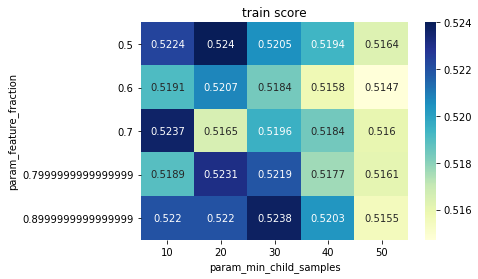

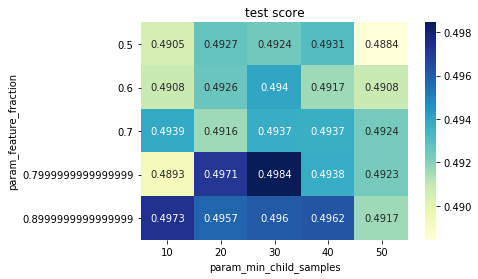

In [85]:
df_gridsearch = pd.DataFrame(gsearch.cv_results_)
max_scores = df_gridsearch.groupby(['param_feature_fraction','param_min_child_samples']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]

sns.heatmap(max_scores.mean_train_score, annot=True, fmt='.4g',cmap='YlGnBu');
plt.title('train score')
plt.show()

sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g',cmap='YlGnBu');
plt.title('test score')
plt.show()

# 套用上面找出的較佳超參數 train model

[1]	train's xentropy: 0.0562307	train's f1: 0	val_1's xentropy: 0.0563429	val_1's f1: 0
Training until validation scores don't improve for 30 rounds.
[2]	train's xentropy: 0.0534821	train's f1: 0	val_1's xentropy: 0.0536745	val_1's f1: 0
[3]	train's xentropy: 0.0510323	train's f1: 0.000130941	val_1's xentropy: 0.051319	val_1's f1: 0.000786782
[4]	train's xentropy: 0.0491242	train's f1: 0.00808608	val_1's xentropy: 0.0494735	val_1's f1: 0.00784006
[5]	train's xentropy: 0.047507	train's f1: 0.0221402	val_1's xentropy: 0.0479078	val_1's f1: 0.0194704
[6]	train's xentropy: 0.0461557	train's f1: 0.0268595	val_1's xentropy: 0.0466181	val_1's f1: 0.02331
[7]	train's xentropy: 0.0449483	train's f1: 0.0313043	val_1's xentropy: 0.0454355	val_1's f1: 0.0301391
[8]	train's xentropy: 0.0438641	train's f1: 0.0441148	val_1's xentropy: 0.0443718	val_1's f1: 0.0504202
[9]	train's xentropy: 0.0429093	train's f1: 0.0598339	val_1's xentropy: 0.043436	val_1's f1: 0.071644
[10]	train's xentropy: 0.0420747	t

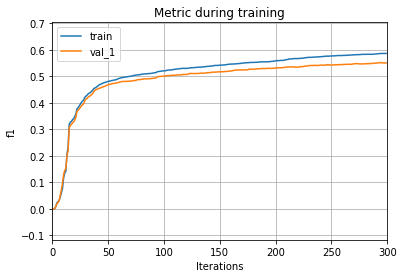

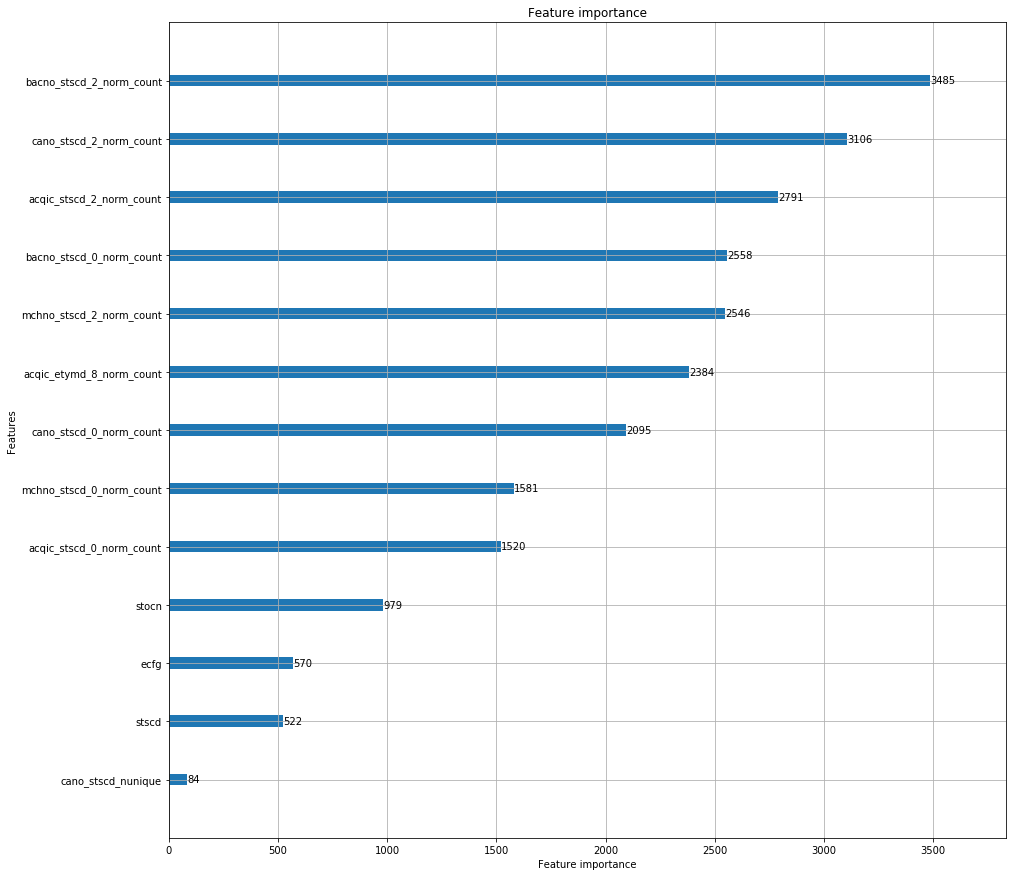

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.723445 to fit


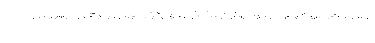

In [86]:
from sklearn.metrics import f1_score
import lightgbm
import numpy as np

# f1 score
def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat)
    return 'f1', f1_score(y_true, y_hat), True

# 定義超參數  
parameters = {
    'boosting_type':'gbdt',
    #'n_estimators':100,
    'objective': 'cross_entropy',
    'metric': 'cross_entropy',
    'num_iterations': 100*3,
    'learning_rate': 0.1/2,
    'max_depth': 7,
    'num_leaves': 2**7-1,
    'feature_fraction': 0.8,
    'tree_learner': 'data',
    "is_unbalance": True,
    "early_stopping_round": 30,
    'min_child_samples': 30,
    #'min_child_weight': 0.001,
    }

# train data
train_data = lightgbm.Dataset(train[features],label=train[y_name],
                              categorical_feature = cat_features)

# val_1_data
val_1_data = lightgbm.Dataset(val_1[features],label=val_1[y_name],
                              categorical_feature = cat_features)

# model training
evals_result = {}
model = lightgbm.train(parameters,
                       train_data,
                       valid_sets=[val_1_data, train_data],
                       valid_names=['val_1','train'], 
                       feval=lgb_f1_score,
                       evals_result=evals_result,
                       )

# plt f1 metric
try:
  lightgbm.plot_metric(evals_result, metric='f1')
  plt.show()
except:
  pass

# plt features importance & save
try:
  ax = lightgbm.plot_importance(model, max_num_features=40, figsize=(15,15))
  plt.savefig("./features_importances.png")
  plt.show()
except:
  pass

# plt tree
try:
  ax = lightgbm.plot_tree(model,tree_index=3)
  plt.show()
except:
  pass

# plt tree_digraph
try:
  graph = lightgbm.create_tree_digraph(model,tree_index=3)
  graph.render(view=True)
except:
  pass

# val_2's F1 report

In [87]:
from sklearn.metrics import classification_report 

val_2_pred_01 = pd.Series(model.predict(val_2[features])).apply(round)

print(classification_report(val_2[y_name],val_2_pred_01,target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00    187682
           1       0.81      0.41      0.55      2542

    accuracy                           0.99    190224
   macro avg       0.90      0.70      0.77    190224
weighted avg       0.99      0.99      0.99    190224



# 產生submission

In [88]:
submission = pd.DataFrame({"txkey":test_txkey,
                           "fraud_ind":model.predict(test[features])})

# to [0,1] 
submission["fraud_ind"] = submission["fraud_ind"].apply(round)

# value_counts
print(submission["fraud_ind"].value_counts())
submission.head()

0    418192
1      3473
Name: fraud_ind, dtype: int64


,txkey,fraud_ind
1521787,592489,0
1521788,592452,0
1521789,590212,0
1521790,590209,0
1521791,592488,0


# 這裡有個想法如果test上盜刷的比例 跟train上面盜刷的比例 愈相近愈好

In [89]:
train_p = round((train['fraud_ind'].value_counts()[1] / #盜刷樣本數
                len(train['fraud_ind']))*100 ,5) #總數

val_1_p = round((val_1['fraud_ind'].value_counts()[1] / #盜刷樣本數
                len(val_1['fraud_ind']))*100 ,5) #總數

val_2_p = round((val_2['fraud_ind'].value_counts()[1] / #盜刷樣本數
                len(val_2['fraud_ind']))*100 ,5) #總數

test_p = round((submission['fraud_ind'].value_counts()[1] / #盜刷樣本數
                len(submission['fraud_ind']))*100 ,5) #總數
pd.DataFrame({'train_p':train_p,
              'val_1_p':val_1_p,
              'val_2_p':val_2_p,
              'test_p':test_p},
               index=['盜刷比例%'])

,train_p,val_1_p,val_2_p,test_p
盜刷比例%,1.33816,1.33527,1.33632,0.82364


# 保存預測結果

In [0]:
submission.to_csv("./submission_30.csv")

In [91]:
print(submission["fraud_ind"].value_counts())

0    418192
1      3473
Name: fraud_ind, dtype: int64
